    <center><img src="amazon1.png" width="200"></center>

# <font color=#ff9900>**NLP Amazon Reviews Project**</font>

In [1]:
## General Libraries 
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt, matplotlib.dates as mdates

## Import Data
import gzip
import glob
import os

import itertools
from collections import Counter

import re  # RegEx

from word2number import w2n  # Convert words to numbers

from sklearn.preprocessing import MinMaxScaler ## Scaler for useful score
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Natural Language Tool Kit
import nltk 
from nltk.corpus import stopwords  # list of stopwords 
from nltk.tokenize import RegexpTokenizer  # RegEx tokenizer
from nltk.stem import SnowballStemmer  # Snowball stemmer 

import langid  #Langauge Detector

import string  # to retrieve list of punctuation

from textblob import Word
from textblob import TextBlob

import jellyfish  # to calculate similarity 

import autokeras
from autokeras import TextRegressor
import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')

### <font color=#ff9900>**Importing Data**</font>

In [2]:
## Provided Functions to convert json Amazon review data into a dataframe

def parse(path):
    ''' Reading gzip file as binary file '''
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    '''Converts json to dataframe'''
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
print('Get current working directory :', os.getcwd())  ## Returns working directory of the ipynb project

Get current working directory : C:\Users\kathl\OneDrive\Documents\Joe Digital Futures\NLP\nlp_project


In [4]:
## Process of the json files being converted and concatenated to a master import dataframe
path = r'C:\Users\kathl\OneDrive\Documents\Joe Digital Futures\NLP\nlp_project'

all_files = glob.glob(os.path.join(path , "*.json.gz"))
li = []

for filename in all_files:
    df = getDF(filename)
    df['category'] = f'{filename}'
    li.append(df)

df_import = pd.concat(li, axis=0, ignore_index=True)

In [5]:
## Adding the category of the reviews to the dataframe
df_import[['directory', 'category']] = df_import['category'].str.split('qa_', expand = True)
df_import['category'] = df_import['category'].str.replace('.json.gz', '')
df_import.drop(columns = 'directory', inplace = True)

In [6]:
## Saving the dataframe to a csv in the same working directory of the project
df_import.to_csv('file.csv')

<br><br><br><br>

### <font color=#ff9900>**Inital Observations & EDA**</font>

In [7]:
## df --> dataframe for EDA
df = df_import.copy()

In [8]:
df.shape

(1396896, 8)

In [9]:
df.head()

,questionType,asin,answerTime,unixTime,question,answerType,answer,category
0,yes/no,B00004U9JP,"Jun 27, 2014",1.403852e+09,I have a 9 year old Badger 1 that needs replac...,?,I replaced my old one with this without a hitch.,Appliances
1,open-ended,B00004U9JP,"Apr 28, 2014",1.398668e+09,model number,NaN,This may help InSinkErator Model BADGER-1: Bad...,Appliances
2,yes/no,B00004U9JP,"Aug 25, 2014",1.408950e+09,can I replace Badger 1 1/3 with a Badger 5 1/2...,?,Plumbing connections will vary with different ...,Appliances
3,yes/no,B00004U9JP,"Nov 3, 2014",1.415002e+09,Does this come with power cord and dishwasher ...,?,It does not come with a power cord. It does co...,Appliances
4,open-ended,B00004U9JP,"Jun 21, 2014",1.403334e+09,loud noise inside when turned on. sounds like ...,NaN,Check if you dropped something inside.Usually ...,Appliances


In [10]:
df.dtypes  ## Data types as expected

questionType     object
asin             object
answerTime       object
unixTime        float64
question         object
answerType       object
answer           object
category         object
dtype: object

In [11]:
df.isna().sum()

questionType         0
asin                 0
answerTime           0
unixTime         49905
question             0
answerType      733030
answer               0
category             0
dtype: int64

In [14]:
## number of empty strings in answers
df[df['answer'] == ''].shape[0]

96

In [15]:
## drop rows with empty answers
df.drop(df[df['answer']== ''].index, inplace=True) 
df[df['answer'] == ''].shape[0]

0

In [16]:
df['category'].nunique()  ## 21 different catergories

21

In [17]:
df['category'].value_counts()  ## The number of reviews by category

Electronics                    314231
Home_and_Kitchen               184425
Sports_and_Outdoors            146886
Tools_and_Home_Improvement     101080
Automotive                      89917
Cell_Phones_and_Accessories     85859
Health_and_Personal_Care        80494
Patio_Lawn_and_Garden           59592
Toys_and_Games                  51482
Office_Products                 43604
Beauty                          42419
Pet_Supplies                    36605
Baby                            28931
Musical_Instruments             23321
Clothing_Shoes_and_Jewelry      22066
Arts_Crafts_and_Sewing          21262
Grocery_and_Gourmet_Food        19537
Video_Games                     13307
Industrial_and_Scientific       12135
Software                        10636
Appliances                       9011
Name: category, dtype: int64

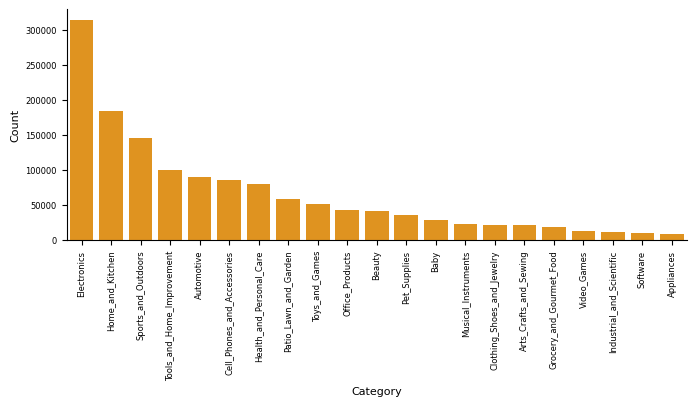

In [18]:
plt.figure(figsize=[8,3])
ax = sns.countplot(data=df, x='category', color = '#ff9900', order = df['category'].value_counts().index)
plt.xticks(size = 6, rotation=90)
plt.yticks(size = 6)
ax.set_xlabel("Category",fontsize=8)
ax.set_ylabel("Count",fontsize=8)
sns.despine()
plt.show()

In [19]:
df[['questionType', 'answerType']].value_counts() ## All answer type categories are from yes/no question type

questionType  answerType
yes/no        ?             328205
              Y             236459
              N              99168
dtype: int64

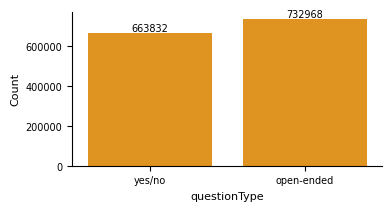

In [20]:
plt.figure(figsize=[4,2])
ax = sns.countplot(data=df, x='questionType', color = '#ff9900')
ax.bar_label(ax.containers[0], size = 7)
plt.xticks(size = 7)
plt.yticks(size = 7)
ax.set_xlabel("questionType",fontsize=8)
ax.set_ylabel("Count",fontsize=8)
sns.despine()
plt.show()

In [21]:
df['questionType'].value_counts(normalize = False)  ## all nulls come from open_ended questions

open-ended    732968
yes/no        663832
Name: questionType, dtype: int64

In [22]:
df['answerType'].fillna('O', inplace = True)  # Hence, casted all nulls as 'O' for open ended

In [23]:
df.isna().sum()  ## Only nulls exist in the unixTime column

questionType        0
asin                0
answerTime          0
unixTime        49903
question            0
answerType          0
answer              0
category            0
dtype: int64

In [24]:
df[['questionType', 'answerType']].value_counts() ## The new anwerType count composition after casting nulls as 'O'

questionType  answerType
open-ended    O             732968
yes/no        ?             328205
              Y             236459
              N              99168
dtype: int64

In [25]:
df['asin'].nunique()  ## 182022 unique products

182022

In [26]:
## Exploring the length of answers and questions
df['answer_length'] = df['answer'].str.len()
df['question_length'] = df['question'].str.len()

In [27]:
df['answer_length'].describe()  ## Large quantity of extreme values

count    1.396800e+06
mean     1.565702e+02
std      2.031736e+02
min      1.000000e+00
25%      4.600000e+01
50%      1.030000e+02
75%      1.990000e+02
max      1.560000e+04
Name: answer_length, dtype: float64

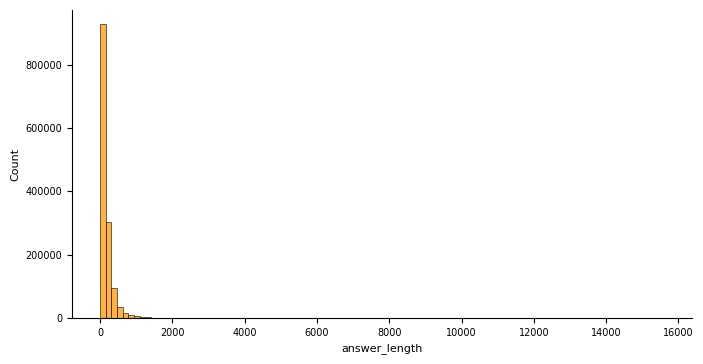

In [28]:
plt.figure(figsize=[8,4])
ax = sns.histplot(data=df ,x='answer_length', bins = 100, color= '#ff9900')
plt.xticks(size = 7)
plt.yticks(size = 7)
ax.set_xlabel("answer_length",fontsize=8)
ax.set_ylabel("Count",fontsize=8)


sns.despine()
plt.show()

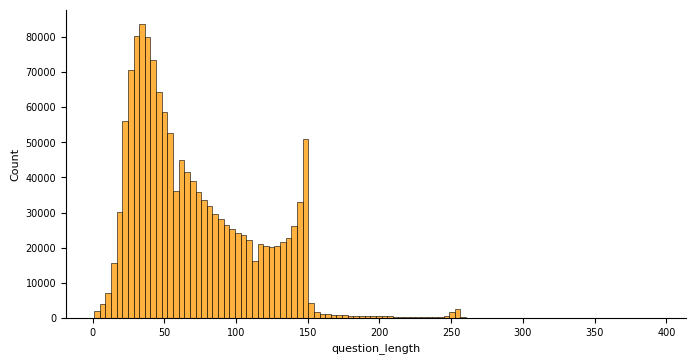

In [29]:
plt.figure(figsize=[8,4])
ax = sns.histplot(data=df ,x='question_length', bins = 100, color='#ff9900')
plt.xticks(size = 7)
plt.yticks(size = 7)
ax.set_xlabel("question_length",fontsize=8)
ax.set_ylabel("Count",fontsize=8)

sns.despine()
plt.show()

In [30]:
df['answer_length'].describe()  ## answer_length numerics more normalised after removing outliers

count    1.396800e+06
mean     1.565702e+02
std      2.031736e+02
min      1.000000e+00
25%      4.600000e+01
50%      1.030000e+02
75%      1.990000e+02
max      1.560000e+04
Name: answer_length, dtype: float64

In [31]:
## DROPING OUTLIERS
df = df.drop(df[df['answer_length'] > 5000].index)  ## Dropping answers above 5000 characters
df = df.drop(df[df['question_length'] > 300].index) ## Dropping answers above 300 characters

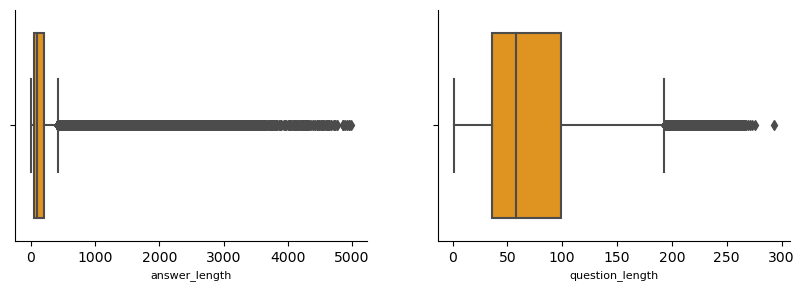

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

ax1 = sns.boxplot(ax=axes[0], data=df, x='answer_length', color='#ff9900')
ax2 =sns.boxplot(ax=axes[1], data=df, x='question_length', color='#ff9900')

ax1.set_xlabel("answer_length",fontsize=8)
ax2.set_xlabel("question_length",fontsize=8)

sns.despine()
plt.show()

In [33]:
## Relationship between answer_length and the questionType
df[df['questionType'] == 'yes/no']['answer_length'].describe()

count    663810.000000
mean        139.839385
std         170.378367
min           1.000000
25%          40.000000
50%          93.000000
75%         181.000000
max        4726.000000
Name: answer_length, dtype: float64

In [34]:
df[df['questionType'] == 'open-ended']['answer_length'].describe()

count    732896.000000
mean        170.802575
std         209.663406
min           1.000000
25%          52.000000
50%         112.000000
75%         216.000000
max        4985.000000
Name: answer_length, dtype: float64

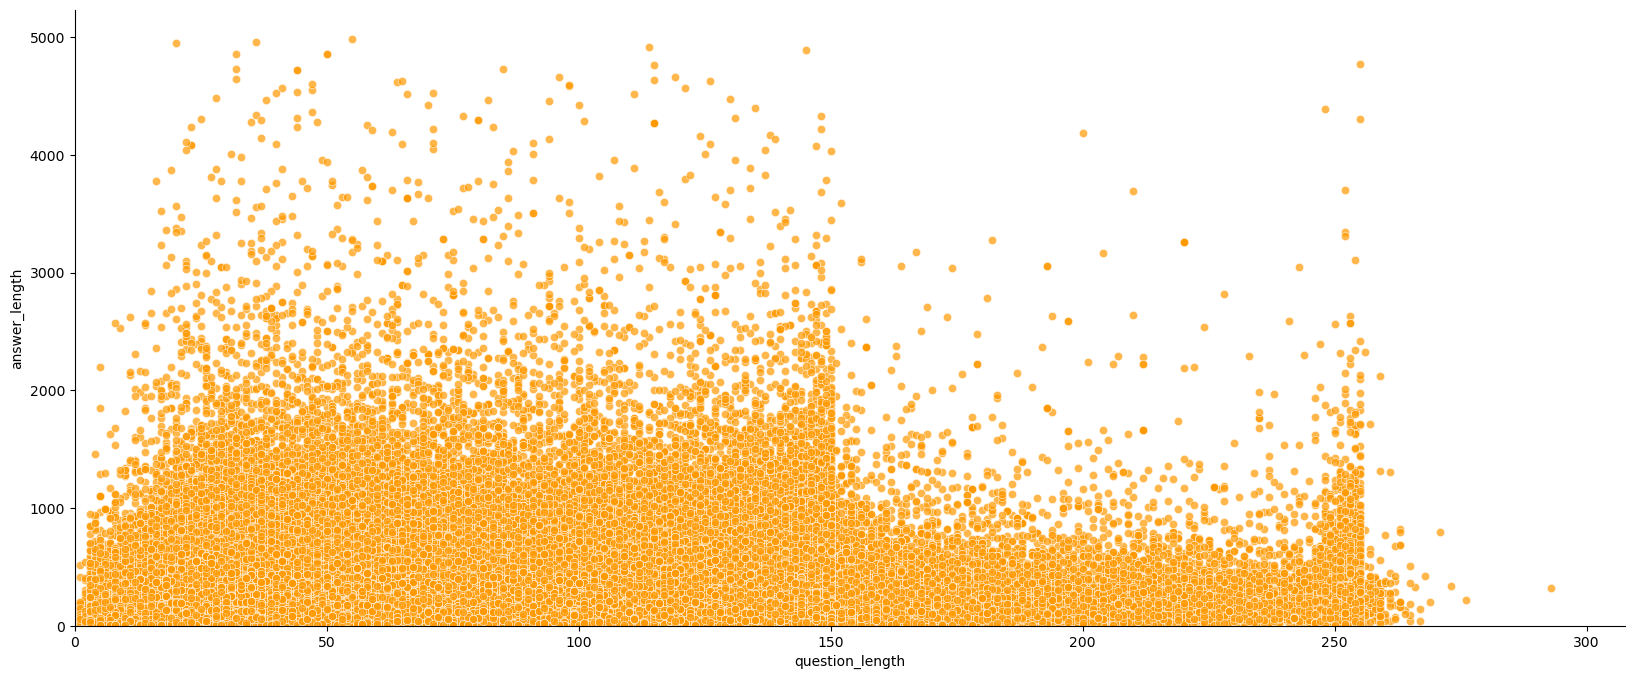

In [35]:
## Relationship between question_length and answer_length
plt.figure(figsize=[20,8])
sns.scatterplot(data=df, x='question_length', y = 'answer_length', color='#ff9900', alpha = 0.7)
plt.ylim(0, None)
plt.xlim(0, None)
sns.despine()
plt.show()

<br><br><br><br>

### <font color=#ff9900>**Cleaning**</font>

In [36]:
# Stratify split df by category
df2 = df.groupby('category', group_keys=False).apply(lambda x: x.sample(min(len(x), 250)))

In [37]:
df2['category'].value_counts()

Appliances                     250
Industrial_and_Scientific      250
Toys_and_Games                 250
Tools_and_Home_Improvement     250
Sports_and_Outdoors            250
Software                       250
Pet_Supplies                   250
Patio_Lawn_and_Garden          250
Office_Products                250
Musical_Instruments            250
Home_and_Kitchen               250
Arts_Crafts_and_Sewing         250
Health_and_Personal_Care       250
Grocery_and_Gourmet_Food       250
Electronics                    250
Clothing_Shoes_and_Jewelry     250
Cell_Phones_and_Accessories    250
Beauty                         250
Baby                           250
Automotive                     250
Video_Games                    250
Name: category, dtype: int64

In [38]:
# df2 --> dataframe for cleaning
df2 = df2[['questionType', 'question', 'answer']]

In [39]:
## Uncomment to run on whole dataframe
# df2 = df[['questionType', 'question', 'answer']].copy()

In [40]:
## Regulary looked at line by line questions and reviews to make observations
n = 5

random_answers = df2.sample(n=n) # selecting nulls
random_answers.reset_index(inplace=True, drop=True)

for i in range(0, n):
    print(random_answers['question'].iloc[i])
    print(random_answers['answer'].iloc[i])
    print('\n ~~~~~~ \n ')

My laptop has a joint audio/mic 3.5mm jack, so theoretically, even the mic should work for my laptop, correct?
yes theoretically that should work just fine but if u buy it and it doesn't i am sure amazon would give you a refund

 ~~~~~~ 
 
Palm splints on any guard I've tried hurt my palm after computer use for an extended period of time. Has anyone else experienced this?
The part of the splint that extends onto my palm is formed to fit, and hasn't caused me any irritation (and I work on a computer all day).

 ~~~~~~ 
 
where can you buy the brake
I purchased this in October 2014 and had it installed. You could have a brake for additional protection but there is no real need. The plugs provided with the system are more than sufficient IMHO.

 ~~~~~~ 
 
I am looking for POWDERED Erythritol. Is this powdered, or grandular???
It's granular

 ~~~~~~ 
 
This or Super Smash Bros?
Both games are excellent. They are totally different kinds of games. If you are a solo player get zelda. If you l

<br><br><br>

In [41]:
## RegEx to expand contractions 
replacement_patterns = [
  (r'won\'t', 'will not'),
  (r'can\'t', 'cannot'),
  (r'i\'m', 'i am'),
  (r'ain\'t', 'is not'),
  (r'(\w+)\'ll', '\g<1> will'),
  (r'(\w+)n\'t', '\g<1> not'),
  (r'(\w+)\'ve', '\g<1> have'),
  (r'(\w+)\'s', '\g<1> is'),
  (r'(\w+)\'re', '\g<1> are'),
  (r'(\w+)\'d', '\g<1> would')
]

def expand_contractions(txt): 
    '''Function to expand contractions'''
    for (pattern, repl) in replacement_patterns:
        txt =  " ".join(re.sub(pattern, repl, txt).split())
    return txt

In [42]:
## Expanding Contractions Example
ex1 = "Hello, I'm Joe and this is Gian. He's lovely and can't be faulted! Wouldn't you love to have him on your team? Bet you're jealous!"
expand_contractions(ex1)

"Hello, I'm Joe and this is Gian. He is lovely and cannot be faulted! Would not you love to have him on your team? Bet you are jealous!"

<br><br><br>

In [43]:
def pre_tagging(text):
    ''' Tagging all colours '''
    colors = 'red blue green black white orange purple yellow grey'
    color_lst = colors.split(' ')
    for color in color_lst:
        text = re.sub(r'\bblue\b|\bred\b|\bgreen\b|\bblack\b|\bwhite\b|\borange\b|\bpurple\b|\byellow\b', 'Colores', text)

    ''' Tagging all links'''
    text = re.sub(r'(http|ftp|https)://([\w-]+(?:(?:.[\w-]+)+))([\w.,@?^=%&:/~+#-][\w@?^=%&/~+#-])', 'Enlace', text)
    text = re.sub(r'www\S+', 'Binki', text)

    return text

In [44]:
## Colour Tagging Example
ex2 = 'I have blue eyes, a red face, black clothes, white socks, orange fake tan, purple earrings, yellow flowers, grey trousers and a green garden'
pre_tagging(ex2)

'I have Colores eyes, a Colores face, Colores clothes, Colores socks, Colores fake tan, Colores earrings, Colores flowers, grey trousers and a Colores garden'

In [45]:
## Link Tagging Example
ex3 = 'https://digitalfutures.com/'
pre_tagging(ex3)

'Enlace'

<br><br><br>

In [46]:
remove_words = [x for x in string.punctuation]

In [47]:
remove_words.remove('?')

In [48]:
remove_words.extend(['i','me','my','myself','we','our','ourselves','you',"you're","you're","you'll","you'd",'your','yours','yourself','yourselves', 'he',
                'him', 'his','himself', 'she',"she's",'her','hers','herself','it', "it's",'its', 'itself', 'they','them','their','theirs', 'themselves',
                'what', 'which', 'who', 'whom','this','that', "that'll",'these', 'those', 'am','is', 'are', 'was', 'were', 'be','been', 'being',
                'have','has', 'had','having','do','does', 'did', 'doing','a', 'an',  'the', 'and', 'but', 'if', 'or', 'because', 'as',
                'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into','through','to','on','all','other','only','too','too','can', 'ma','will','just','now',
                'd','m', 'o', 'y'])

In [49]:
remove_words.extend(['', '…','...', '--']) 

In [50]:
## Remove 'thank you' and 'thanks'
remove_words.extend(['thank', 'thanks', 'thx', 'cheers'])

In [51]:
## Remove salutations
remove_words.extend(['hello', 'hey', 'hi', 'dear', 'hiya'])

In [52]:
## Snowball Stemmer
s_stemmer = SnowballStemmer(language='english')

In [53]:
def clean_tokens(answer):
    ''' Final cleans, removing meaningless characters, convert num to str etc. '''
    answer = [word for word in answer if word not in remove_words]

    clean_list = []
    for word in answer:
        try:
            word = str(w2n.word_to_num(word))
        except:
            word = word
        clean_list.append(word)

    clean_list = [word.replace("-","") for word in clean_list]
    clean_list = [s_stemmer.stem(word) for word in clean_list]
    clean_list = [word for word in clean_list if word not in remove_words]

    ''' unlisting the final answer '''
    clean_list = " ".join(clean_list)

    return clean_list

In [54]:
## Prep our data
def prep_data(answer):

    ''' Function to prep the data '''
    answer = answer.lower()

    answer = pre_tagging(answer)
    answer = expand_contractions(answer)

    ## Part 2 - Tokenize
    answer = RegexpTokenizer(r'\w+').tokenize(answer)

    ## Part 3 - Clean tokens
    answer = clean_tokens(answer)

    return answer 

In [55]:
for column in ['question', 'answer']:
    df2[f'{column}_clean'] = df2[column].apply(prep_data)

<br><br><br><br><br>

### <font color=#ff9900>**Scoring Function**</font>

In [56]:
df2 = df2[['questionType','question','question_clean','answer', 'answer_clean']]

In [57]:
df2.reset_index(drop = True, inplace = True)

In [58]:
def scorer(text, df):
    ''' Function to score answers '''
   
    #text = prep_data(text)
    def get_adjectives(text):
        text = ' '.join(text)
        blob = TextBlob(text)
        return len([ word for (word,tag) in blob.tags if tag == "JJ" or tag == 'JJR' or tag =='JJS' or tag =='NNP'])
    df['adj_count'] = text.apply(get_adjectives)

    #Extract VERBS
    def get_verbs(text):
        text = ' '.join(text)
        blob = TextBlob(text)
        return len([word for (word, tag) in blob.tags if tag == "VBZ" or tag == 'VBD' or tag == 'VB'])
    df['vrb_count'] = text.apply(get_verbs)

    
    #Extracts DIGITS
    def get_digits(text):
        text = ' '.join(text)
        num = re.findall(r'\d+', text)
        return len(num)
    df['num_count'] = text.apply(get_digits)
    
    
    #Get Colors
    def get_color(text):
        text = ' '.join(text)
        colour = re.findall(r'colores', text)
        return len(colour)
    df['colour_count'] = text.apply(get_color)
    
    
    #Get Link
    def get_links(text):
        text = ' '.join(text)
        link = re.findall(r'enlace', text)
        return len(link)
    df['link_count'] = text.apply(get_links)
    


    # Get Units
    def get_units(text):
        units = ['n', 'inch', 'iches', 'cm', 'm', 'foot', 'ft', 'amps', 'volts', 'v', 'frequency', 'hertz', 'diameter',
                 'radius', 'litres', 'l', 'mm', 'celcius', 'kelvin', 'gallon', 'degree', 'degrees', 'min', 'mins', 'hours',
                 'hr', 'hour', 'dimension', 'dimensions', 'height', 'width', 'length', 'high', 'tall', 'deep', 'wide',
                 'long', 'widest', 'top', 'bottom', 'lbs']
        count = 0
        for x in text:
            if x in units:
                count = + 1
            else:
                pass
        return count
    df['units_count'] = text.apply(get_units)
    
    
    #Extract useless word
    def get_useless(text):
        useless = ['sorry', 'apologise', 'apolgize', 'apologies', 'idk', 'dunno']
        count = 0
        for x in text:
            if x in useless:
                count = + 1
            else:
                pass
        return count
    df['useless_count'] = text.apply(get_useless)

    #Score Calculation
    def score_calculator(df):
        adj = df['adj_count']
        vrb = df['vrb_count']
        dig = df['num_count']
        col = df['colour_count']
        lnk = df['link_count']
        uni = df['units_count']
        usl = df['useless_count']
        total_score = adj*4 + vrb*2 + dig*5 + col*3 + lnk*2 + uni*5 - usl*3
        return  total_score
    df['total_score'] = score_calculator(df)

    return df

In [59]:
scaler = MinMaxScaler()

In [60]:
def confident_similarity(df):
    df['score2'] = ''
    similarity = []
    for i in range(0,len(df)):
        if (df['questionType'][i] == 'yes/no') & (('yes' in df['answer_clean'][i]) | ('no' in df['answer_clean'][i])):
            df['score2'][i] = 100
            jelly = jellyfish.damerau_levenshtein_distance(df['question_clean'][i], df['answer_clean'][i])
            similarity.append(jelly)
        else:
            df['score2'][i] = 0
            jelly = jellyfish.damerau_levenshtein_distance(df['question_clean'][i], df['answer_clean'][i])
            similarity.append(jelly)
    df['similarity'] = similarity
    df[df['similarity'] == 0] = 1
    df['new_sim'] = 1 - (df['similarity']/10)
    #df['new_sim'] = pd.to_numeric(10-(((df['similarity']) * 10) / (max(df['similarity'])-min(df['similarity'])))) #Scaling similarity 0 to 10
    return df


In [ ]:
scorer(df2['answer_clean'], df2)
confident_similarity(df2)

In [62]:
df2.head()

,questionType,question,question_clean,answer,answer_clean,adj_count,vrb_count,num_count,colour_count,link_count,units_count,useless_count,total_score,score2,similarity,new_sim
0,yes/no,How long (in feet) is the hose? Product dimens...,how long in feet hose product dimens say 42inc...,that was about right- and it worked great!,right work great,0,1,0,0,0,0,0,2,0,69,-5.9
1,open-ended,At what minimal height do we actually need to ...,minim height actual need instal filter allow c...,"Fully assembled it is about 15 inches, you'll ...",fulli assembl 15 inch need anoth 10 inch insta...,34,12,8,0,0,1,0,205,0,251,-24.1
2,open-ended,How noisy is this machine,how noisi machin,I would not call it noisy but you can hear it ...,would not call noisi hear run compressor make ...,13,5,1,0,0,1,0,72,0,115,-10.5
3,open-ended,Is this product hard wired or can it be plugge...,product hard wire plug,Hard wired. See installation manual on the Bro...,hard wire see instal manual broan websit enlac,3,0,0,0,0,1,0,17,0,36,-2.6
4,yes/no,are all washing machine connection standard?,wash machin connect standard,To my experience yes.,experi yes,1,0,0,0,0,0,0,4,100,24,-1.4


In [63]:
def final_score(df):
    df['final_score'] = ''
    
    for column in ['total_score', 'score2', 'new_sim']:
        df[column] = pd.to_numeric(df[column])
    
    df['final_score'] =  df['total_score'] + df['score2'] + df['new_sim']
    
    df[df['final_score'] == 0] = 1
    df['final_score'] = np.log(df['final_score']) + 20
    
    
    
    df.drop(columns=['total_score', 'score2', 'new_sim', 'adj_count', 'vrb_count', 'num_count', 'colour_count', 'link_count',
       'units_count', 'useless_count', 'similarity'], inplace=True)
    return df

In [64]:
final_score(df2)

,questionType,question,question_clean,answer,answer_clean,final_score
0,yes/no,How long (in feet) is the hose? Product dimens...,how long in feet hose product dimens say 42inc...,that was about right- and it worked great!,right work great,NaN
1,open-ended,At what minimal height do we actually need to ...,minim height actual need instal filter allow c...,"Fully assembled it is about 15 inches, you'll ...",fulli assembl 15 inch need anoth 10 inch insta...,25.197944
2,open-ended,How noisy is this machine,how noisi machin,I would not call it noisy but you can hear it ...,would not call noisi hear run compressor make ...,24.119037
3,open-ended,Is this product hard wired or can it be plugge...,product hard wire plug,Hard wired. See installation manual on the Bro...,hard wire see instal manual broan websit enlac,22.667228
4,yes/no,are all washing machine connection standard?,wash machin connect standard,To my experience yes.,experi yes,24.630838
...,...,...,...,...,...,...
5245,open-ended,i am havin windows 8.1 will it work,havin window 8 1 work,Yes it will work as it is not the system that ...,yes work not system caus not work game program...,23.131137
5246,open-ended,what ps3 system will play ps2 games,ps3 system play ps2 game,Mine didn't work had to send back sorry,mine not work send back sorri,23.238678
5247,yes/no,"Do they come with batteries, if so what size, ...",come batteri so size brand type batteri,2 AA batteries.,2 aa batteri,21.163151
5248,yes/no,is the software user friendly?,softwar user friend,It is easy to start up and easy to use to set ...,easi start up easi use set up key start key al...,25.515040


In [65]:
df2['final_score'] = scaler.fit_transform(df2[['final_score']])

In [66]:
df2.final_score.describe()

count    5184.000000
mean        0.675390
std         0.112640
min         0.000000
25%         0.601917
50%         0.700968
75%         0.761513
max         1.000000
Name: final_score, dtype: float64

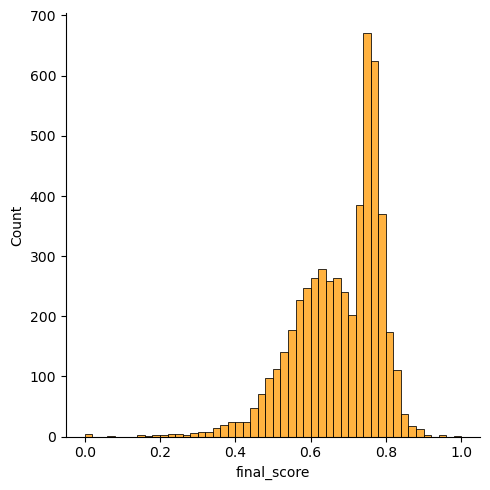

In [68]:
sns.displot(data = df2, x=df2['final_score'], bins = 50, color = '#ff9900')
sns.despine()
plt.show()

<br><br><br><br><br>

### <font color=#ff9900>**Modelling**</font>

In [ ]:
df3 = df2.copy()

In [ ]:
df3  = df3[['answer_clean', 'final_score']]  ## Text regressors only take in two columns

X= df3[['answer_clean']]  ## Independent Variable
Y= df3[['final_score']]  ## Dependent Variable


df3 = tf.data.Dataset.from_tensor_slices((X.values, Y.values))   ## Convert into tensor flow dataset

iv = []
dv = []
for x in df3:
    i = x[0].numpy()
    iv.append(i[0])
    dv.append(int(x[1].numpy()))
iv = np.array(iv)
dv = np.array(dv)



X_train, X_test, Y_train, Y_test = train_test_split(iv, dv,   test_size=0.20)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)



train_set = tf.data.Dataset.from_tensor_slices(((X_train,), (Y_train,))).batch(32)
test_set = tf.data.Dataset.from_tensor_slices(((X_test,), (Y_test,))).batch(32)

reg = TextRegressor(overwrite=True, max_trials=1)
# Feed the tensorflow Dataset to the regressor.
reg.fit(train_set, epochs=5)



# Predict with the best model.
predicted_y = reg.predict(test_set)
# Evaluate the best model with testing data.
print(reg.evaluate(test_set))

<br><br><br><br><br>

### <font color=#ff9900>**Function**</font>

In [ ]:
def project_function():
    
    ''' Ask QnA'''
 
    qt = int(input('What type of question will you be asking today? Please input 0 for yes/no and 1 for open-ended, thank you!'))
    if qt == 0:
        qt = 'yes/no'
    else:
        qt = 'open-ended'

    
    while True:
        q = input('Please enter your question: ')
        if len(q) > 300:
            print("\nYour question must be below 300 characters!\n")
        else:
             break

    while True:
        a = input('Please enter your answer: ')
        if len(a) > 5000:
            print("\nYour answer must be below 5000 characters!\n")
        else:
             break
    


    dictionary = {'questionType':qt,'question_clean':q, 'answer_clean': a}

    df_project = pd.DataFrame(dictionary, index=[0])
    df_project['answer_clean'] = df_project['answer_clean'].apply(prep_data)
    df_project = scorer(df_project['answer_clean'], df_project)
    df_project = confident_similarity(df_project)
    
    df_project = final_score(df_project)
    
    df_project['final_score'] = scaler.transform(df_project[['final_score']])
    
    score = df_project['final_score']
     
    ## Display usefullness score
    print(f'The usefullness of your answer to the question {q} is: {score}')
    


In [80]:
project_function()

What type of question will you be asking today? Please input 0 for yes/no and 1 for open-ended, thank you! 0
Please enter your question:  Is it the color blue?
Please enter your answer:  yes!


The usefullness of your answer to the question Is it the color blue? is: 0    0.734974
Name: final_score, dtype: float64


<br><br><br><br><br>

### <font color=#ff9900>**Project Improvements**</font>

1. **Cleaning**
    - Seperate units from digits, e.g, '7in' would be cleaned and tokenized as '7' 'in', rather than '7in'
    - Convert unit puntuation into the corresponding string, e.g, 7" or 7' into 7 in 
    - RegEx to remove the first word after a salutation as upon observation most of the time the following word would be the name of person asking the question
    
2. **Score Function**
    - Include Question Content Metric
    - Spend more time playing around with the weighting

3. **Code**
    - Make code more robust